In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

### Define processing funtion

- Reads input data files:
  - `y_train.txt` containing paper IDs and their associated classes.
  - `edgelist.txt` containing paper ID pairs representing links between papers. <br><br>

- Processes the input data to create a dictionary (`paper_links_with_classes`) with the following structure:
  - Key: paper ID
  - Value: a dictionary containing:
    - 'links': a list of linked paper IDs
    - 'classes': a list of classes corresponding to the linked paper IDs <br><br>

- Counts occurrences of each class in the linked papers and updates `paper_links_with_classes` to include class counts.

- Converts the `paper_links_with_classes` dictionary to a pandas DataFrame.

- Calculates class weights for each paper based on the counts of each class in their linked papers and adds them as new columns to the DataFrame.

- Saves the resulting DataFrame to a CSV file (`output_csv_path`).

In [4]:
def process_edgelist_data(y_train_path: Path, edgelist_path: Path, output_csv_path: Path) -> pd.DataFrame:

    '''
    This function gets as input the paths of the required files and the required name from the csv file output.
    It returns a dataframe from better understanding the results.
    Also, it saves the result as a csv file 
    '''

    # Initialize the dictionary with keys from 0 to 166985 and empty lists as values
    paper_links = {i: [] for i in range(166986)}

    # Read the edgelist.txt file
    with open(edgelist_path, "r") as f:
        lines = f.readlines()

    # Parse the data and assign values bidirectionally
    for line in lines:
        paper_id, linked_paper_id = map(int, line.strip().split())

        # Assign the linked_paper_id to the paper_id key if not already present
        if linked_paper_id not in paper_links[paper_id]:
            paper_links[paper_id].append(linked_paper_id)

        # Assign the paper_id to the linked_paper_id key if not already present
        if paper_id not in paper_links[linked_paper_id]:
            paper_links[linked_paper_id].append(paper_id)

    # Read the y_train.txt file
    with open(y_train_path, "r") as f:
        lines = f.readlines()

    # Create a dictionary with paper_id as key and class as value
    paper_classes = {}
    for line in lines:
        paper_id, paper_class = map(int, line.strip().split(','))
        paper_classes[paper_id] = paper_class

    # Add class information to the paper_links dictionary
    paper_links_with_classes = {}
    for paper_id, linked_papers in paper_links.items():
        paper_links_with_classes[paper_id] = {
            'links': linked_papers,
            'classes': [paper_classes.get(linked_paper_id) for linked_paper_id in linked_papers if linked_paper_id in paper_classes]
        }

    # Count occurrences of each class in the linked papers
    for paper_id, info in paper_links_with_classes.items():
        class_counts = {'class0': 0, 'class1': 0, 'class2': 0, 'class3': 0, 'class4': 0}

        for paper_class in info['classes']:
            class_name = f'class{paper_class}'
            class_counts[class_name] += 1

        paper_links_with_classes[paper_id].update(class_counts)

    # Convert the paper_links_with_classes dictionary to a DataFrame
    data = []
    for paper_id, info in paper_links_with_classes.items():
        row = {'paper_id': paper_id}
        row.update(info)
        data.append(row)

    df = pd.DataFrame(data)

    # Calculate class weights and rearrange columns
    for i in range(5):
        class_count_column = f'class{i}'
        class_weight_column = f'class{i}_weight'
        df[class_weight_column] = df[class_count_column] / df[[f'class{j}' for j in range(5)]].sum(axis=1)

    # Add total_references column
    df['total_references'] = df[[f'class{j}' for j in range(5)]].sum(axis=1)

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv_path, index=False)
    return df

### Results

In [5]:
# Set the absolute path to your data directory
data_directory = Path("E:/panag/Desktop/Ms Data Science/6 Quarter/Data Science Challenge/data_challenge_aueb_2023")

# Train data
y_train_file = "y_train.txt"
# Edgelist data
edgelist_file = "edgelist.txt"
# Test data
test_file = "test.txt"

y_train_path  = data_directory / y_train_file
edgelist_path = data_directory / edgelist_file
test_path     = data_directory / test_file
output_csv_path =  "features_edgelist.csv"

df = process_edgelist_data(y_train_path, edgelist_path, output_csv_path)

df.head(5)

,paper_id,links,classes,class0,class1,class2,class3,class4,class0_weight,class1_weight,class2_weight,class3_weight,class4_weight,total_references
0,0,[138097],[1],0,1,0,0,0,0.000000,1.0,0.000000,0.000000,0.000000,1
1,1,"[44164, 38118]",[2],0,0,1,0,0,0.000000,0.0,1.000000,0.000000,0.000000,1
2,2,"[132575, 36628, 21383, 103558, 103665, 99219, ...","[2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]",0,0,2,0,13,0.000000,0.0,0.133333,0.000000,0.866667,15
3,3,"[158930, 20562, 36447, 157194, 16449, 97870, 1...","[3, 0, 3]",1,0,0,2,0,0.333333,0.0,0.000000,0.666667,0.000000,3
4,4,"[95168, 133558]",[3],0,0,0,1,0,0.000000,0.0,0.000000,1.000000,0.000000,1


### Plot

From the whole dataframe we filter only the paper ids that exist in train and test data. We plot a histogramm of the percentage of paper ids and the distinct number of classes they linked papers belong.

Papers with no class:               4982
Percentage of papers with no class: 12.71 %


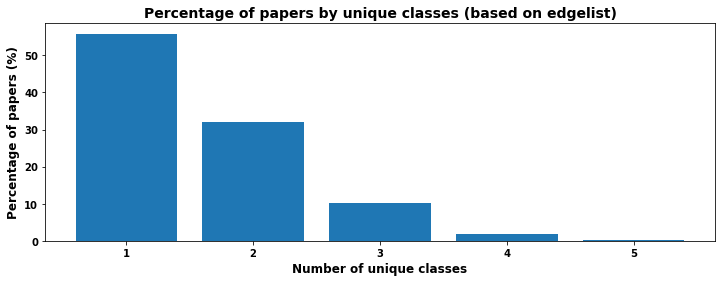

In [35]:
# Import train dataset
df_train = pd.read_csv(y_train_path, header = None)
df_train.columns = ['paper_id', 'class']
paper_train_tuple = tuple(df_train.paper_id)
# Import test dataset
df_test = pd.read_csv(test_path, header = None)
df_test.columns = ['paper_id', 'class']
paper_test_tuple = tuple(df_test.paper_id)
# Total paper ids 
paper_id_tuple = paper_train_tuple + paper_test_tuple
# Get only relevant paper ids (train/test dataset)
df_train_test = df[df['paper_id'].isin(paper_id_tuple)]
# Convert to dict
paper_dict = df_train_test.set_index('paper_id')['classes'].to_dict()


# Count unique classes for each paper
paper_classes = {paper: len(set(classes)) for paper, classes in paper_dict.items()}

# Count the number of papers for each number of unique classes and also track papers with no class
class_counts = defaultdict(int)
no_class_papers = 0

for paper, num_classes in paper_classes.items():
    if num_classes == 0:
        no_class_papers += 1
    else:
        class_counts[num_classes] += 1

# Print the number of papers with no class
print(f"Papers with no class:               {no_class_papers}")
print(f"Percentage of papers with no class: {format(no_class_papers/len(df_train_test)*100, '.2f')} %")

# Calculate the total number of papers that belong to a class
total_papers_with_class = len(paper_dict) - no_class_papers

# Calculate the percentage for each class count
class_percentages = {k: (v / total_papers_with_class) * 100 for k, v in class_counts.items()}

# Plot
plt.figure(figsize=(12, 4))
plt.bar(class_percentages.keys(), class_percentages.values())
plt.xlabel('Number of unique classes', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of papers (%)', fontsize=12, fontweight='bold')
plt.title('Percentage of papers by unique classes (based on edgelist)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.show()